## <center>Team-5</center>

## <center>Homework 3. Популярные модели для тёплых и холодных пользователей</center>

## 2. Тёплые и Холодные пользователи

In [64]:
import requests
from itertools import product
import warnings
from typing import Dict, List

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import mode 
from pprint import pprint
import pickle

from rectools.metrics import Precision, Recall, MAP, MeanInvUserFreq, Serendipity, calc_metrics
from rectools import Columns
from rectools.dataset import Dataset

# from rectools import Columns
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

In [13]:

# download dataset by chunks
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

!unzip kion_train.zip


kion dataset download: 100%|█████████▉| 78.6M/78.8M [00:02<00:00, 39.4MiB/s]

Archive:  kion_train.zip
replace kion_train/interactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [14]:

interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

# rename columns, convert timestamp
interactions.rename(columns={'last_watch_dt': "datetime"}, inplace=True) 
interactions['datetime'] = pd.to_datetime(interactions['datetime'])

interactions["user_id"] = interactions["user_id"].astype(np.uint32)
interactions["item_id"] = interactions["item_id"].astype(np.uint16)
interactions["total_dur"] = interactions["total_dur"].astype(np.uint16)
interactions["watched_pct"] = interactions["watched_pct"].astype(np.float32)

kion dataset download: 100%|██████████| 78.8M/78.8M [00:19<00:00, 39.4MiB/s]

In [37]:
interactions.columns = [
    'user_id', 
    'item_id', 
    'datetime', 
    Columns.Weight, 
    'watched_pct'
]

#### для теплых и холодных пользователей предлагается использовать бейзлайн с популярными 

In [38]:
# Preparing of the Hot Users
threshold = 10
users_inter_count = interactions.groupby("user_id")["item_id"].count()
hot_users = users_inter_count[users_inter_count >= threshold].index.values

hot_interactions = interactions[interactions["user_id"].isin(hot_users)].sort_values(["user_id", "datetime"])
hot_interactions["order"] = hot_interactions.groupby("user_id").cumcount(ascending=False)
hot_interactions["order"] = hot_interactions["order"].astype(np.uint16)

print("Hot users: ", hot_users.shape[0])
print("Hot interactions: ", hot_interactions.shape[0])
hot_interactions.tail(12)

Hot users:  145410
Hot interactions:  3260927


,user_id,item_id,datetime,weight,watched_pct,order
537061,1097544,13973,2021-08-21,3089,58.0,1
5157263,1097544,1000,2021-08-21,67,1.0,0
3622193,1097554,11275,2021-04-06,7825,100.0,9
1497465,1097554,1053,2021-04-10,12,100.0,8
4150064,1097554,849,2021-04-12,6521,100.0,7
4840760,1097554,9169,2021-04-14,7378,100.0,6
4450562,1097554,3509,2021-04-15,14076,100.0,5
1474297,1097554,496,2021-04-20,2,0.0,4
3818420,1097554,4580,2021-04-20,22404,100.0,3
885465,1097554,16361,2021-04-22,6662,100.0,2


In [39]:
# Preparing of the warm users
warm_users = users_inter_count[users_inter_count < threshold].index.values
warm_interaсtions = interactions[interactions["user_id"].isin(warm_users)].sort_values(["user_id", "datetime"])
print("Warm users: ", warm_users.shape[0])
print("Warm interactions: ", warm_interaсtions.shape[0])
warm_interaсtions.head(12)

Warm users:  816769
Warm interactions:  2215324


,user_id,item_id,datetime,weight,watched_pct
3590116,0,12192,2021-07-16,89,0.0
620,0,7102,2021-07-19,169,3.0
67070,0,14359,2021-07-19,130,2.0
90113,0,15297,2021-07-19,459,0.0
3103040,0,9728,2021-07-19,4,0.0
1213765,0,6006,2021-07-20,1,0.0
2354936,1,10440,2021-08-13,19579,80.0
1625374,1,3669,2021-08-16,1593,26.0
4299412,4,6317,2021-06-02,14,0.0
114632,4,4700,2021-07-02,5799,97.0


## Решили протестировать кросс-валидацию на временных рядах. 

### Размер выборки и максимальное количество действий 
Мы используем датасет с горячими пользователями. В процессе написания функции, возникла идея, брать не весь датасет для построения модели популярных.

Будут ли средние метрики лучше, если:

Решили потестировать c T, где T -- число на дату которого считаются метрики:
- Если взять весь датасет
- Ограничиться T - delta, где delta -- количество дней

Решили потестровать с ограничением количество взаимодействий на пользователя.

In [40]:
def calc_metrics_popular_by_date(
    hot_interactions: pd.DataFrame,
    metrics: Dict,
    delta_days: int = None,
    max_interactions: int = None
):

    """
    interactions: pd.DataFrame - взаисодействия пользователя
    metrics: Dict - какие метрики нужно рассчитать?
    delta_days: int - максимальное число дней в выборке
    max_interactions: int - максимальное количество действий на одного юзера

    Возвращает pandas DataFrame с рассчитанными метриками
    """

    date_range = pd.date_range(
        hot_interactions.datetime.min(), 
        hot_interactions.datetime.max()
    )
    # делаю date range  для того чтобы пройтись по датасету
    # и предсказывать на следующую дату
    interactions_date_range = pd.DataFrame(columns=hot_interactions.columns)
    calced_metrics = {}

    if max_interactions is not None:
        hot_interactions = (
            hot_interactions.loc[
                hot_interactions['order']<=max_interactions
            ]
        )


    for i_fold, date in enumerate(date_range[:-1]):

        train_ids = hot_interactions.loc[
            hot_interactions[Columns.Datetime] == date
        ].index
        test_ids = hot_interactions.loc[
            hot_interactions[Columns.Datetime] == date+pd.Timedelta(days=1)
        ].index

        X_train = hot_interactions.loc[train_ids].copy()
        X_test = hot_interactions.loc[test_ids].copy()

        interactions_date_range = pd.concat([
            interactions_date_range, 
            X_train,
            X_test
        ])

        if delta_days is not None:
            
            interactions_date_range = interactions_date_range.loc[
                interactions_date_range[Columns.Datetime] >= (
                    date+pd.Timedelta(days=1) -
                    pd.Timedelta(days=delta_days)
                )
            ]

        X_test = X_test[Columns.UserItem]

        catalog = interactions_date_range[Columns.Item].unique()

        
        dataset = Dataset.construct(
            interactions_df=interactions_date_range,
        )

        simple_popular = PopularModel(add_cold=True)
        simple_popular.fit(dataset)

        # использую rec
        recos = simple_popular.recommend(
            X_test[Columns.User], 
            dataset=dataset, 
            k=10, 
            filter_viewed=False
        )
        
        metric_values = calc_metrics(
                    metrics,
                    reco=recos,
                    interactions=X_test,
                    prev_interactions=X_train,
                    catalog=catalog,
                )
        calced_metrics[f'{(date+pd.Timedelta(days=1)).strftime("%y-%m-%d")}'] = metric_values
    calced_metrics_df = pd.DataFrame(calced_metrics).T
    return calced_metrics_df, simple_popular


def make_plot(
    calced_metrics: pd.DataFrame,
    k_for_metrics: int
) -> None:
    # make plot 

    x_tick = calced_metrics.index.values.copy()
    x_tick[::2] = ''

    fig, ax = plt.subplots(figsize=(15,6))

    ax = plt.plot(calced_metrics.drop(['novelty'],axis=1), )
    plt.vlines(x_tick, ymin=0, ymax=0.6, linestyles=':', colors='grey')
    plt.xticks(x_tick, )
    fig.autofmt_xdate(rotation=90)
    plt.legend(calced_metrics.drop(['novelty'],axis=1).columns)
    plt.title('Metrics for Pop model')
    
    text_1 = f"k = {k_for_metrics}"
    text_2 = "prec@k:{0:.3f}".format(calced_metrics[f'prec@{k_for_metrics}'].mean())
    text_3 = "map@k:{0:.3f}".format(calced_metrics[f'recall@{k_for_metrics}'].mean())
    text_4 = "novelty:{0:.3f}".format(calced_metrics[f'map@{k_for_metrics}'].mean())
    text_5 = "serendipity:{0:.3f}".format(calced_metrics['serendipity'].mean())
    _text = [text_1, text_2, text_3, text_4, text_5]
    plt.text(0, 0.65, "\n".join(_text))

    plt.show()

def calc_metrics_make_plot(
    hot_interactions: pd.DataFrame,
    delta_days: int = None,
    max_interactions: int = None,
    k_for_metrics: int = 10
) -> None:

    if k_for_metrics is None:
        k_for_metrics = 10

    # Метрики тоже должны меняться
    metrics = {
        f"prec@{k_for_metrics}": Precision(k=k_for_metrics),
        f"recall@{k_for_metrics}": Recall(k=k_for_metrics),
        f"map@{k_for_metrics}": MAP(k=k_for_metrics),
        "novelty": MeanInvUserFreq(k=k_for_metrics),
        "serendipity": Serendipity(k=k_for_metrics),
    }

    calced_metrics_df, _ = calc_metrics_popular_by_date(
        hot_interactions, 
        metrics, 
        delta_days,
        max_interactions
    )
    make_plot(
        calced_metrics_df, 
        k_for_metrics
    )
    

### Проведем исследование. Посмотрим, как меняются значения метрик в зависимости от количества T - дней в датасете, от изменения максимального количества взаимодействий.

max_interactions: None 
 delta_days: None


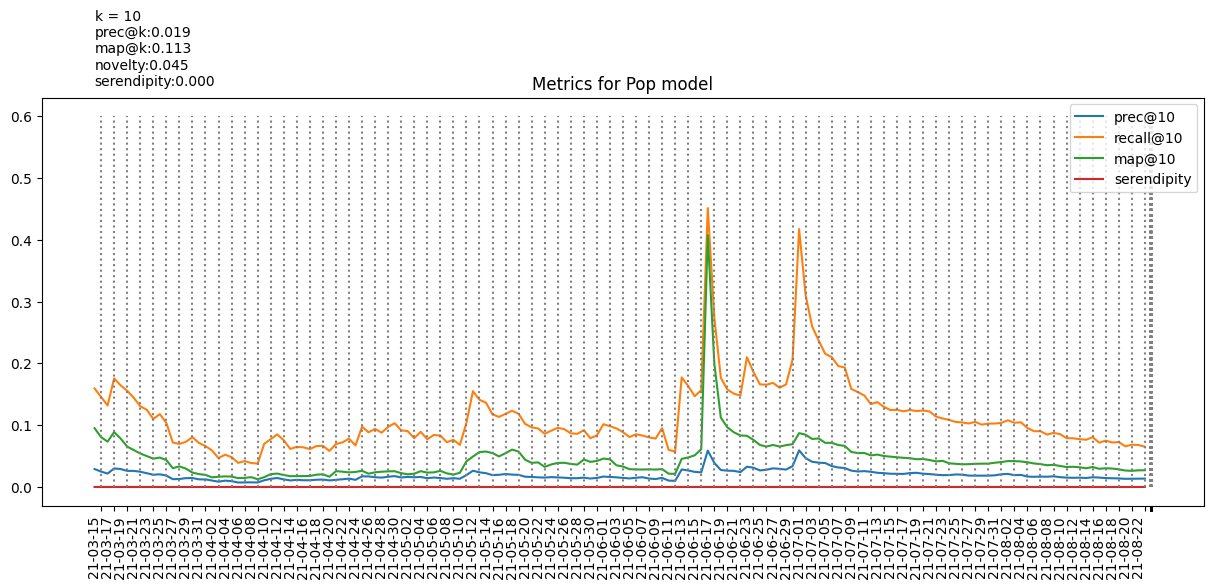

max_interactions: 10 
 delta_days: 14


KeyboardInterrupt: 

In [44]:
delta_days = [None, 14, 7, 3, 1]
max_interactions = [None, 10, 5, 3, 1]

for days,max_iter in zip(delta_days, max_interactions):

    print("max_interactions:", max_iter,"\n", "delta_days:", days)
    calc_metrics_make_plot(
        hot_interactions,
        days,
        max_iter,
        max_iter
    )

In [45]:
# если больше одного графика, в одном output, графики не отображаются

Что ж, интересно.
А если зафиксировать max_interactions

max_interactions: 10 
 delta_days: None


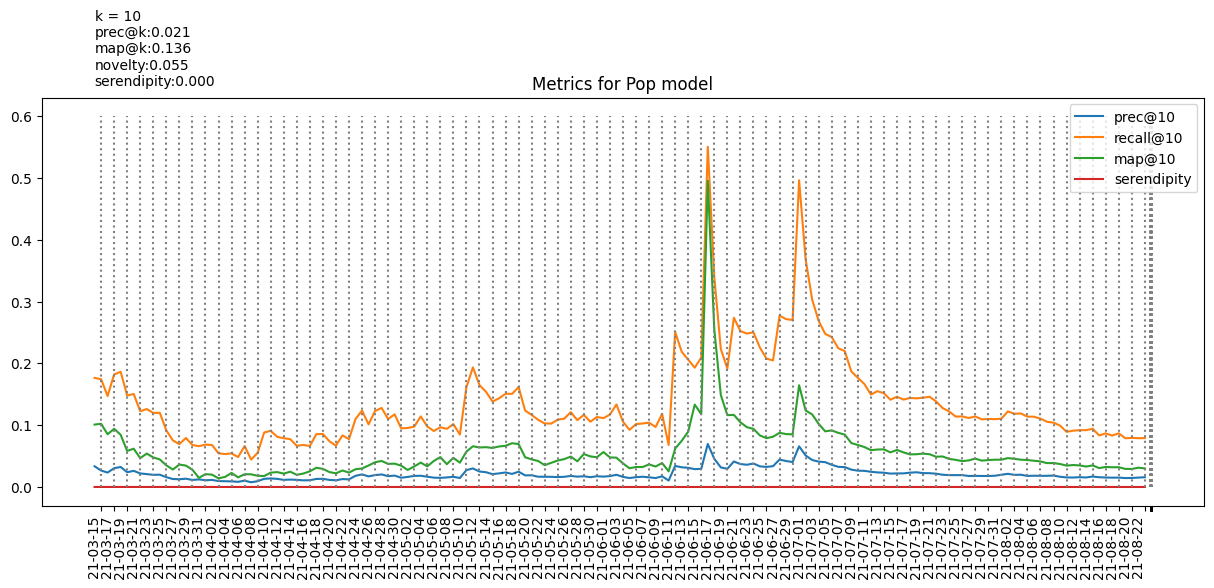

max_interactions: 10 
 delta_days: 14


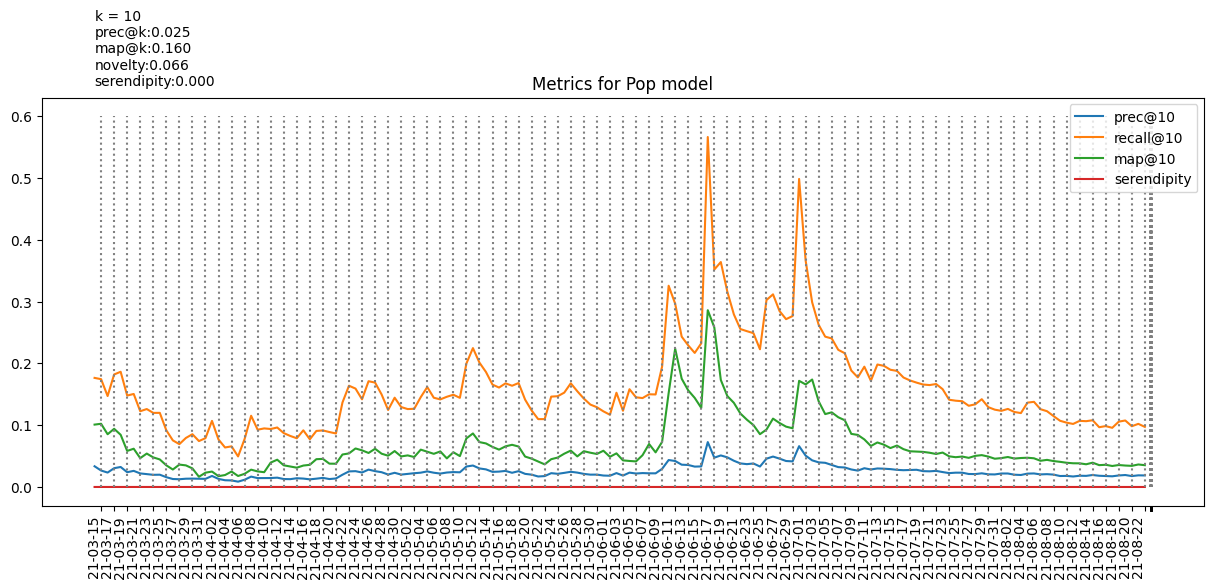

max_interactions: 10 
 delta_days: 7


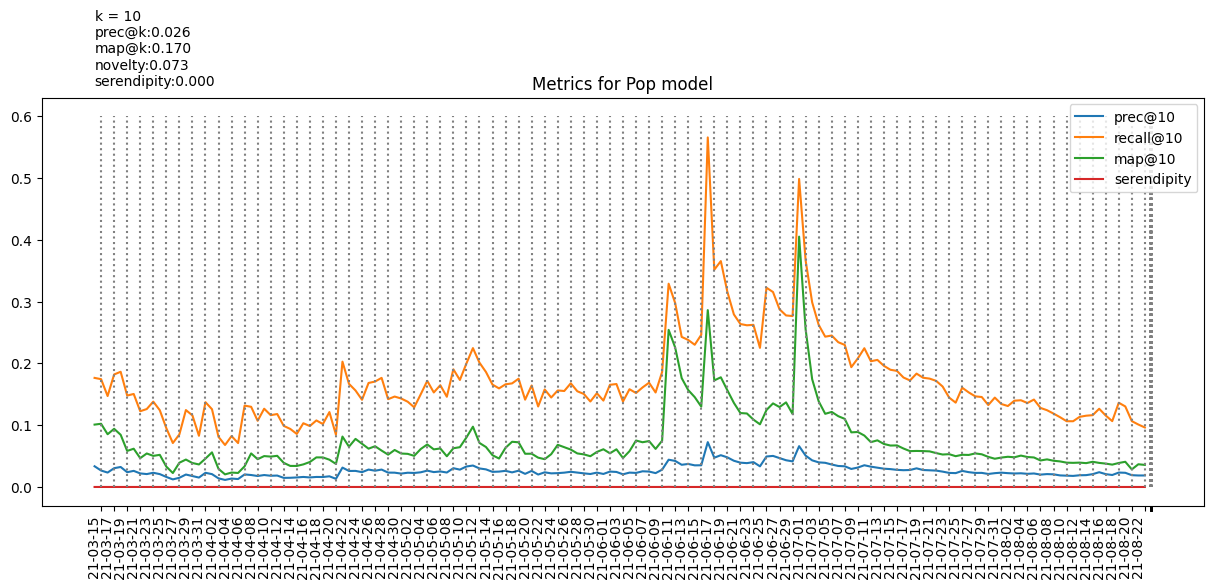

max_interactions: 10 
 delta_days: 3


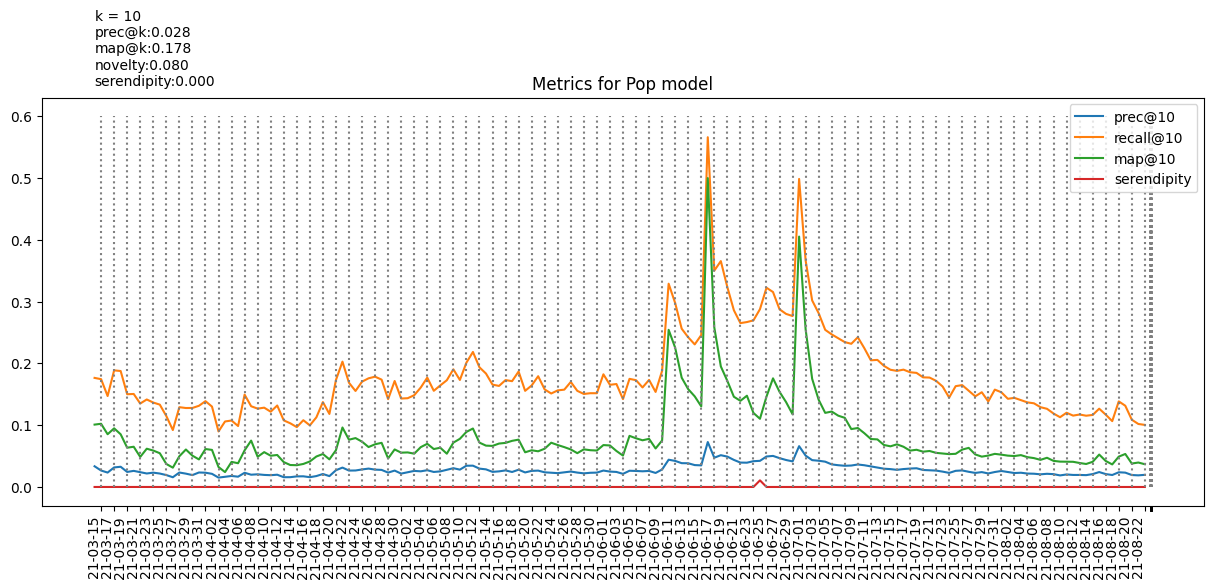

max_interactions: 10 
 delta_days: 1


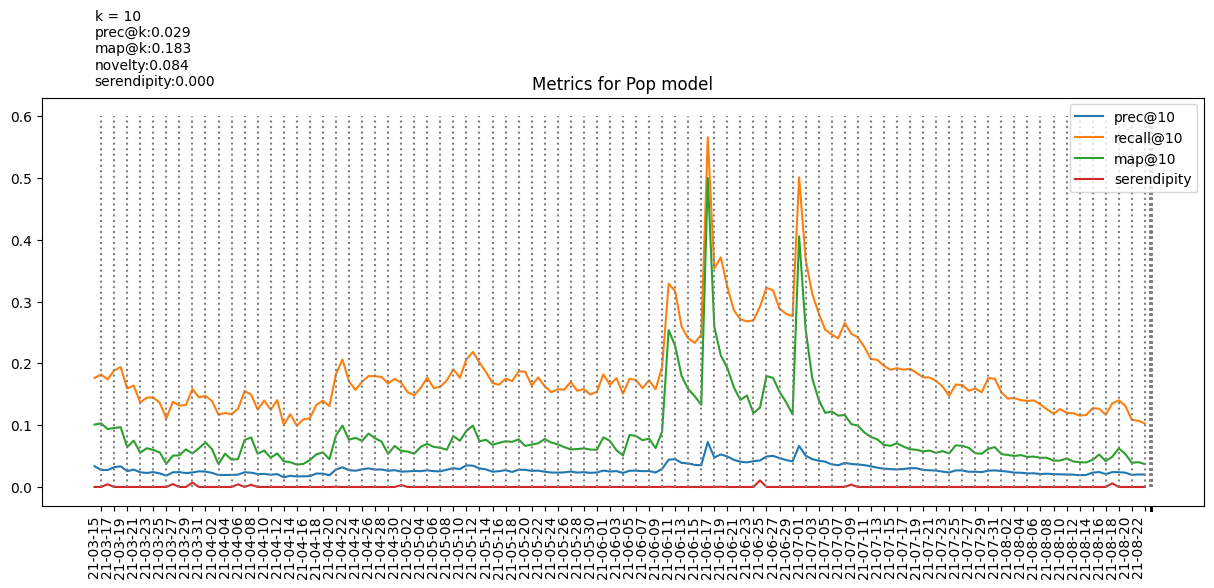

In [47]:
delta_days = [None, 14, 7, 3, 1]
max_iter = 10

for days in delta_days:

    print("max_interactions:", max_iter,"\n", "delta_days:", days)
    calc_metrics_make_plot(
        hot_interactions,
        days,
        max_iter,
        max_iter
    )

Чем ближе к T, тем выше метрики. Логично. 
Теперь зафиксиреум delta_t

max_interactions: None 
 delta_days: 1


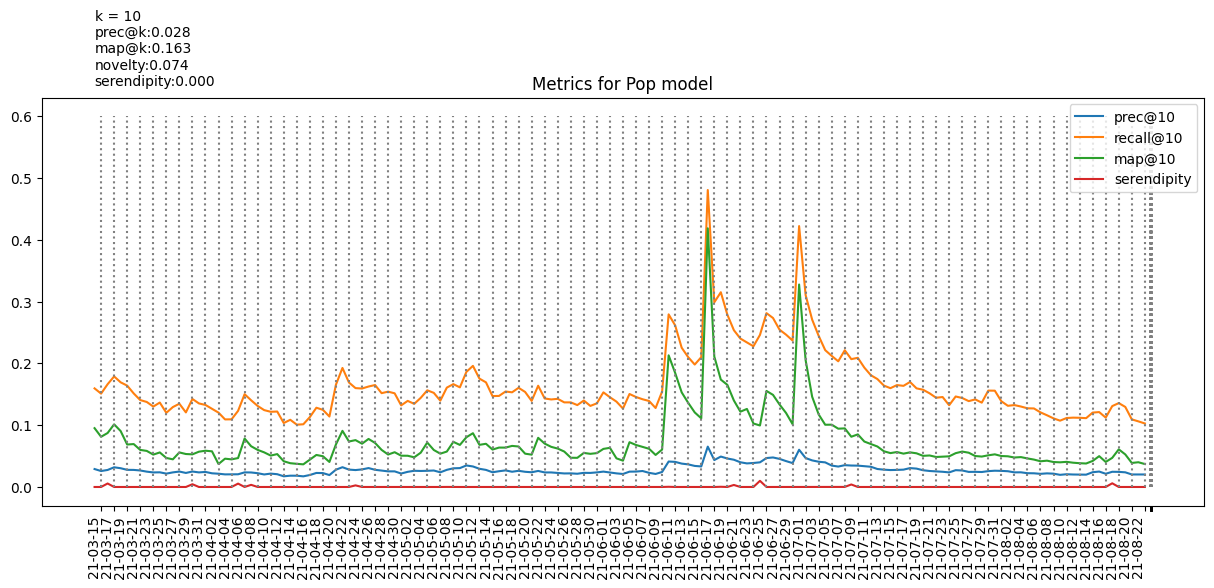

max_interactions: 10 
 delta_days: 1


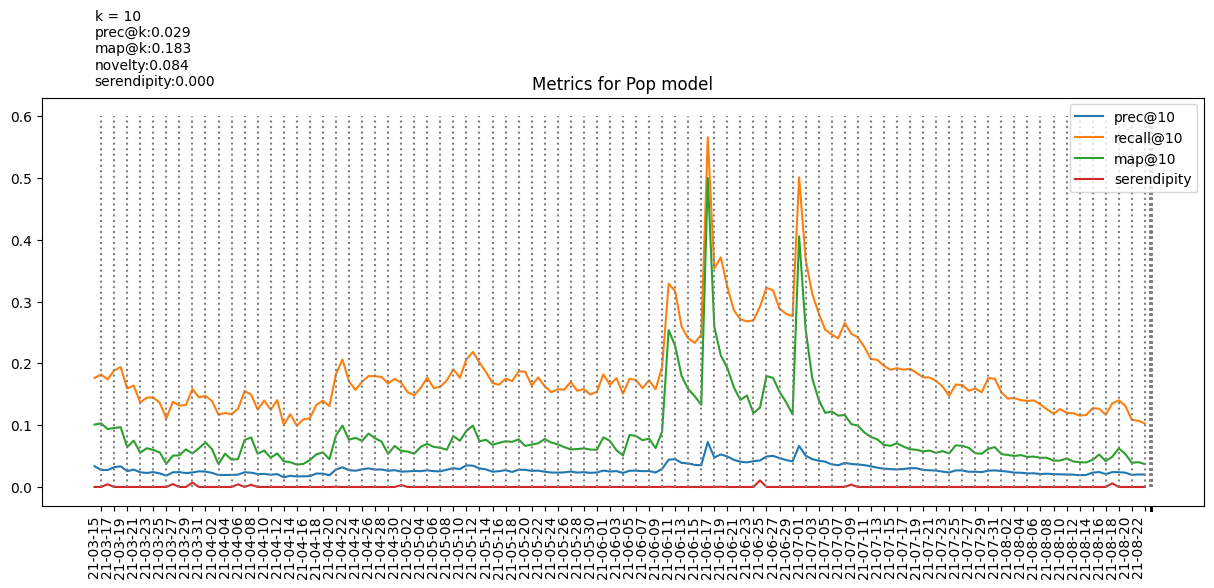

max_interactions: 5 
 delta_days: 1


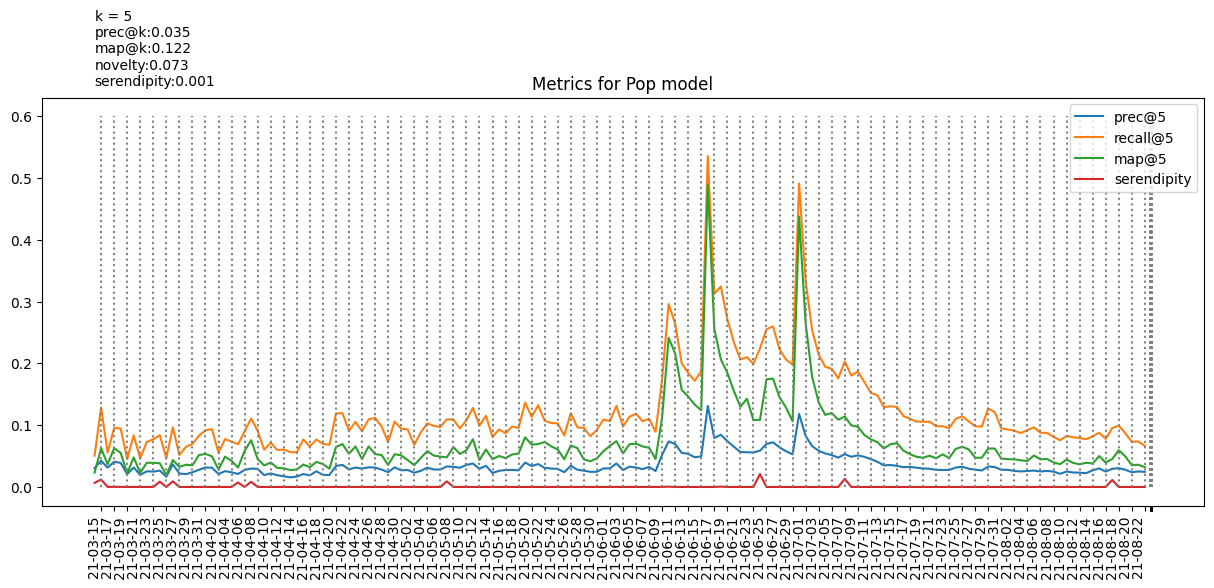

max_interactions: 3 
 delta_days: 1


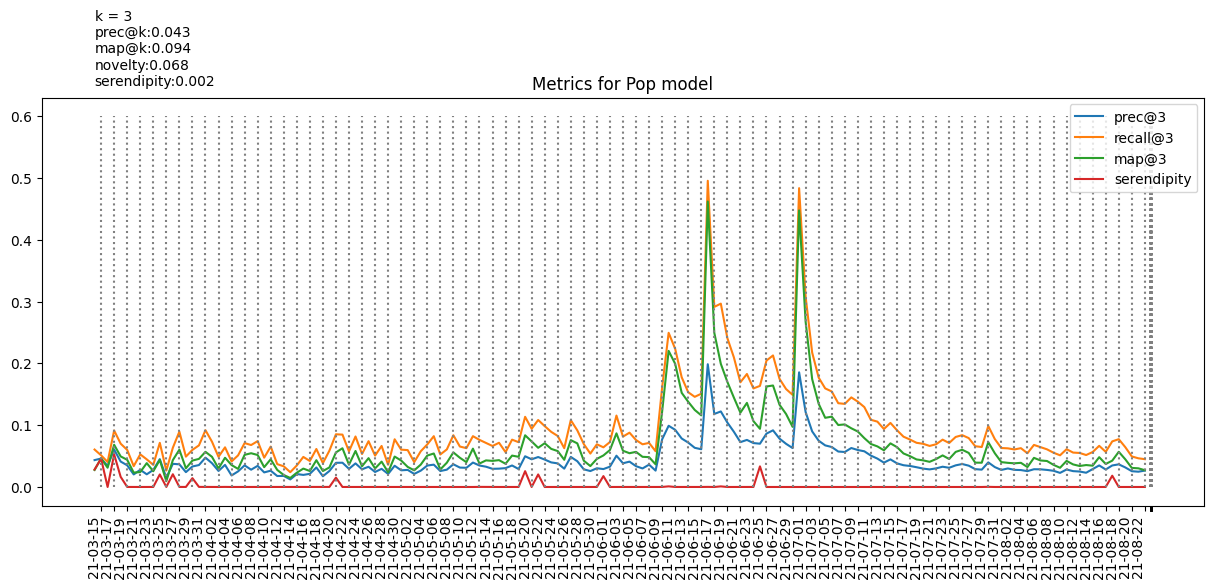

max_interactions: 1 
 delta_days: 1


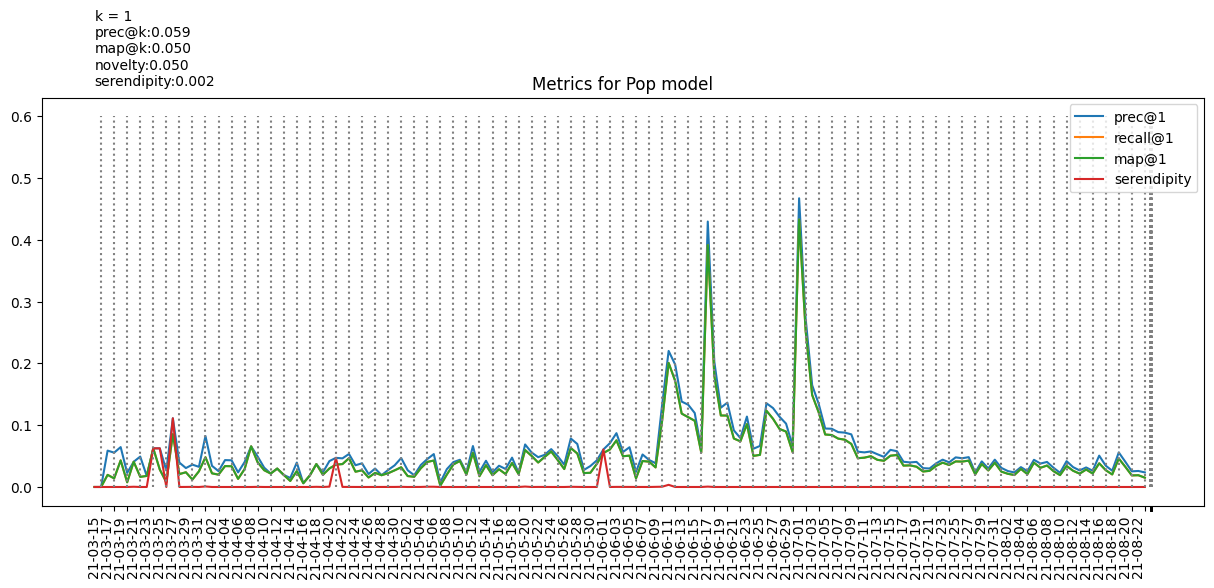

In [49]:
delta_days = [1, 1, 1, 1, 1]
max_interactions = [None, 10, 5, 3, 1]

for days,max_iter in zip(delta_days, max_interactions):

    print("max_interactions:", max_iter,"\n", "delta_days:", days)
    calc_metrics_make_plot(
        hot_interactions,
        days,
        max_iter,
        max_iter
    )

Получается можно не нужно брать популярного дальше T-1 дней. Достаточно 10 взаимодействий

`max_interactions: 10 
 delta_days: 1`

Для юзеров, которых нет в БД, нужно делать популярную рекомендацию.

Для неизвестных юзеров буду просто брать самые популярные.

### В исследовании проведенном выше, становится понятно, что лучшей стратегией будет использовать взаимодействия за последний день.

Можно попробовать рассчитать для каждой категории юзеров свои популярные и использовать их для предсказания

In [51]:
# взаимодействия на последнюю дату
date_range = pd.date_range(
        hot_interactions.datetime.min(), 
        hot_interactions.datetime.max()
    )

last_datetime = hot_interactions.loc[hot_interactions.datetime == date_range[-1]]

In [52]:
# юзеры на последнюю дату
last_users = users.loc[users.user_id.isin(last_datetime.user_id)].fillna(np.nan)

In [53]:
last_users

,user_id,age,income,sex,kids_flg
98,206243,age_35_44,income_40_60,М,1
165,675297,age_65_inf,income_40_60,М,0
195,855990,age_45_54,income_40_60,М,0
201,565410,age_35_44,income_60_90,М,0
329,81723,age_35_44,income_60_90,М,1
...,...,...,...,...,...
839870,557988,age_25_34,income_20_40,М,0
839885,428464,NaN,income_0_20,Ж,0
839931,454037,age_55_64,income_20_40,М,0
840029,244725,age_18_24,income_20_40,М,0


Попробую сделать предсказания для каждой категории юзеров в отдельности

In [56]:
age_list = last_users.age.unique()

income_list = last_users.income.unique()

sex_list = last_users.sex.unique()

kids_list = [0, 1]

# все варианты юзеров
# для перебора всех комбинаций юзеров возьмем ф. product
# из itertools
categories = product(age_list, income_list, sex_list, kids_list)
cat_list = list(categories)

cat_list[:5]

[('age_35_44', 'income_40_60', 'М', 0),
 ('age_35_44', 'income_40_60', 'М', 1),
 ('age_35_44', 'income_40_60', 'Ж', 0),
 ('age_35_44', 'income_40_60', 'Ж', 1),
 ('age_35_44', 'income_40_60', nan, 0)]

#### С помощью rectools сделаем словарь с рекомендациями для каждой категории юзеров. Если в категории меньше 50 юзеров, будем считать что такое количество не позволит сделать адекватную рекомендацию. Для такой категории будем использовать популярные посчитанные для всего датасета

In [57]:
dictionary = {}
popular_dictionary = {}
users_dictionary = {}
catalog = last_datetime[Columns.Item].unique()
k_recs = 20
# лист для специфичных юзеров
espetial_users = []
for spec in cat_list:

    user_list = (
        last_users
        .loc[last_users.age == spec[0]]
        .loc[last_users.income == spec[1]]
        .loc[last_users.sex == spec[2]]
        .loc[last_users.kids_flg == spec[3]]
    ).user_id.values
    # если мало статистики для категории юзера
    # будем предлагать популярное для всех
    if user_list.shape[0]<50:
        espetial_users.append(user_list)
        continue

    # возьмем взаимодействия этих пользователей
    intercations_spec_user = last_datetime.loc[
        last_datetime.user_id.isin(user_list)
    ]
    dataset = Dataset.construct(
        interactions_df = intercations_spec_user,
    )

    simple_popular = PopularModel(add_cold=True)
    simple_popular.fit(dataset)
    
    recos = list(simple_popular.recommend(
        users = [user_list[0]],
        dataset=dataset,
        k = k_recs,
        filter_viewed = True
    ).item_id)
    popular_dictionary['_'.join([str(x) for x in spec])] = recos
    for u in user_list:
        users_dictionary[u] = '_'.join([str(x) for x in spec])

In [58]:
# популярные итемы для неизвестных пользователей 
dataset = Dataset.construct(
    interactions_df = last_datetime,
)

simple_popular = PopularModel(add_cold=True)
simple_popular.fit(dataset)

recos = list(simple_popular.recommend(
        users = [106],
        dataset=dataset,
        k = k_recs,
        filter_viewed = True
    ).item_id)
popular_dictionary['popular_for_all'] = recos

In [61]:
# функция для рекомендации 
def get_popular_reco(
    user_id: int,
    k_recs: int
) -> List:
    try:
        category = users_dictionary[user_id]
        reco = popular_dictionary[category][:k_recs]
    except KeyError:
        reco = popular_dictionary['popular_for_all'][:k_recs]
    return reco

In [62]:
print(get_popular_reco(733907, 10))
print(get_popular_reco(-1, 10))
print(get_popular_reco(550385, 10))

[14488, 9728, 5543, 11640, 4218, 3734, 4151, 341, 15297, 512]
[14488, 12192, 9728, 15297, 5543, 10440, 4218, 341, 512, 13865]
[15297, 12192, 9728, 7571, 14488, 341, 3734, 512, 10440, 5565]


In [65]:
# сохраняю словари
# Будем использовать их для рекомендаций в сервисе 
pickle.dump(popular_dictionary, open('../service/reco_models/popular_dictionary.pickle', 'wb'))
pickle.dump(users_dictionary, open('../service/reco_models/users_dictionary.pickle', 'wb'))
